## Loading Information from BigQuery

In [1]:
%load_ext google.cloud.bigquery

In [2]:
%%bigquery

select * from `jchavezar-demo.vertex_datasets_public.credit-openml` limit 10

Query is running:   0%|          |

Downloading:   0%|          |

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,no checking,9.0,existing paid,furniture/equipment,1980.0,<100,<1,2.0,female div/dep/mar,co applicant,...,car,19.0,none,rent,2.0,skilled,1.0,none,True,bad
1,<0,12.0,existing paid,furniture/equipment,1282.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,car,20.0,none,rent,1.0,skilled,1.0,none,True,bad
2,no checking,12.0,existing paid,used car,4675.0,no known savings,<1,1.0,female div/dep/mar,none,...,car,20.0,none,rent,1.0,skilled,1.0,none,True,good
3,0<=X<200,24.0,existing paid,radio/tv,1967.0,<100,>=7,4.0,female div/dep/mar,none,...,car,20.0,none,own,1.0,skilled,1.0,yes,True,good
4,no checking,15.0,existing paid,new car,3186.0,>=1000,4<=X<7,2.0,female div/dep/mar,none,...,car,20.0,none,rent,1.0,skilled,1.0,none,True,good
5,no checking,9.0,existing paid,furniture/equipment,1313.0,<100,>=7,1.0,male single,none,...,car,20.0,none,own,1.0,skilled,1.0,none,True,good
6,<0,24.0,existing paid,furniture/equipment,2996.0,no known savings,1<=X<4,2.0,male mar/wid,none,...,car,20.0,none,own,1.0,skilled,1.0,none,True,bad
7,no checking,15.0,existing paid,furniture/equipment,2221.0,500<=X<1000,1<=X<4,2.0,female div/dep/mar,none,...,car,20.0,none,rent,1.0,skilled,1.0,none,True,good
8,<0,24.0,existing paid,business,6568.0,<100,1<=X<4,2.0,male mar/wid,none,...,car,21.0,stores,own,1.0,unskilled resident,1.0,none,True,good
9,0<=X<200,18.0,existing paid,used car,2779.0,<100,1<=X<4,1.0,male mar/wid,none,...,car,21.0,none,rent,1.0,skilled,1.0,yes,True,good


## Set Variables

In [3]:
PROJECT_ID = 'jchavezar-demo'
PREDICTION_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest'
STAGING_BUCKET = 'gs://vtx-staging'

## Data Preprocessing

In [5]:
## Loading data from BigQuery locally
from google.cloud import bigquery

client = bigquery.Client(project='jchavezar-demo')
sql = f"""
    SELECT * 
    FROM `jchavezar-demo.vertex_datasets_public.credit-openml`
"""
df = client.query(sql).to_dataframe()
X_raw = df.iloc[:,:-1]  # features (pandas DataFrame)
y_raw = df.target  # labels (pandas Series)

In [6]:
## Feature Engineering
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

SEED = 123456
np.random.seed(SEED)
random.seed(SEED)
    
cat_features = X_raw.select_dtypes(["object", "bool"]).columns
num_features = X_raw.select_dtypes("float64").columns

# Encoding from string to 0s and 1s
X_encoded = pd.get_dummies(X_raw, columns=cat_features, drop_first=True)
y = y_raw.map({"bad": 0, "good": 1})  # encode labels as integers
    
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.25,random_state=SEED,)

# Standarization
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

## Training and Evaluation

Test accuracy of original logistic regression: 0.748


<AxesSubplot:>

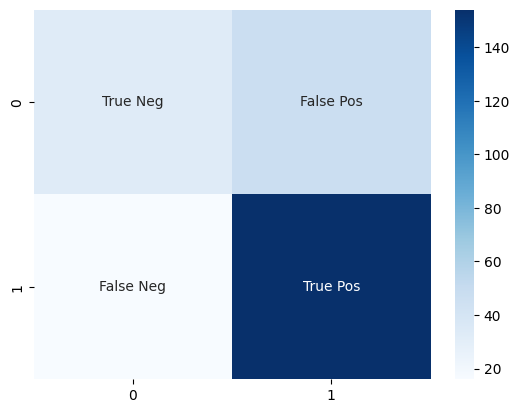

In [7]:
## Local Training
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)
acc_og = clf.score(X_test, y_test)
print(f"Test accuracy of original logistic regression: {acc_og}")
    
# Testing
y_test_pred = clf.predict(X_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=labels, fmt='', cmap='Blues')

In [8]:
## Save and Upload Model to Google Cloud Storage
import pickle
import pathlib

file_name = "/tmp/model.pkl"
with open(file_name, "wb") as file:
    pickle.dump(clf, file)

In [9]:
!gsutil cp /tmp/model.pkl gs://vtx-models/credits/sklearn/model.pkl

Copying file:///tmp/model.pkl [Content-Type=application/octet-stream]...
/ [1 files][  2.6 KiB/  2.6 KiB]                                                
Operation completed over 1 objects/2.6 KiB.                                      


## Upload to Vertex Endpoint and Deploy

In [3]:
from google.cloud import aiplatform as aip

aip.init(project=PROJECT_ID, location='us-central1')

## Upload to Model Registry (tracking versioning)
model_reg = aip.Model.upload(
    display_name='credits-sklearn-v1',
    serving_container_image_uri=PREDICTION_IMAGE,
    artifact_uri='gs://vtx-models/credits/sklearn',

)

Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/8373020739049095168/operations/1380817073537548288
Model created. Resource name: projects/569083142710/locations/us-central1/models/8373020739049095168@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/8373020739049095168@1')


In [4]:
## Deploy Model on Vertex
model_reg.deploy(
    machine_type='n1-standard-4'
)

Creating Endpoint
Create Endpoint backing LRO: projects/569083142710/locations/us-central1/endpoints/4795009791149735936/operations/8539288681242951680
Endpoint created. Resource name: projects/569083142710/locations/us-central1/endpoints/4795009791149735936
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/569083142710/locations/us-central1/endpoints/4795009791149735936')
Deploying model to Endpoint : projects/569083142710/locations/us-central1/endpoints/4795009791149735936
Deploy Endpoint model backing LRO: projects/569083142710/locations/us-central1/endpoints/4795009791149735936/operations/2508124355263725568


In [10]:
## Open Samples for Testing over Vertex Endpoint
import json
with open('sample_for_prediction.json', 'r') as f:
    x = json.load(f)

In [12]:
from google.cloud import aiplatform as aip
## Predicting with Endpoint
model_name = aip.Endpoint.list()[0].resource_name

for i in aip.Endpoint(endpoint_name=model_name).predict(x['instances']):
    print(i)
    break

[1.0]


In [74]:
X_test.to_csv('test.csv', index=False)

In [75]:
x_test =X_test.copy()
x_test['target'] = y_test

[python library description](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_upload)